In [1]:
import numpy as np 
import pandas as pd 
import os 
import librosa 
import librosa.display
import IPython.display as ipd
import wave 
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
import matplotlib.pyplot as plt
from keras.models import load_model

In [2]:
crema_directory_list = os.listdir("/kaggle/input/cremad/AudioWAV/")

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append("/kaggle/input/cremad/AudioWAV/" + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


In [3]:
ipd.Audio(Crema_df.iloc[0,1])

In [4]:
Crema_df.replace({'Emotions':{'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}},inplace=True)

In [5]:
sig, sr = librosa.load(Crema_df.iloc[0,1])
print(sig.shape)

(53709,)


In [6]:
data = {
        "labels": [],
        "mfcc": []
    }
# Loading and feature extraction from audio
for i in range(7442):
    data['labels'].append(Crema_df.iloc[i,0])
    signal, sample_rate = librosa.load(Crema_df.iloc[i,1])
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i%500==0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [7]:
data["mfcc"][0].shape

(105, 13)

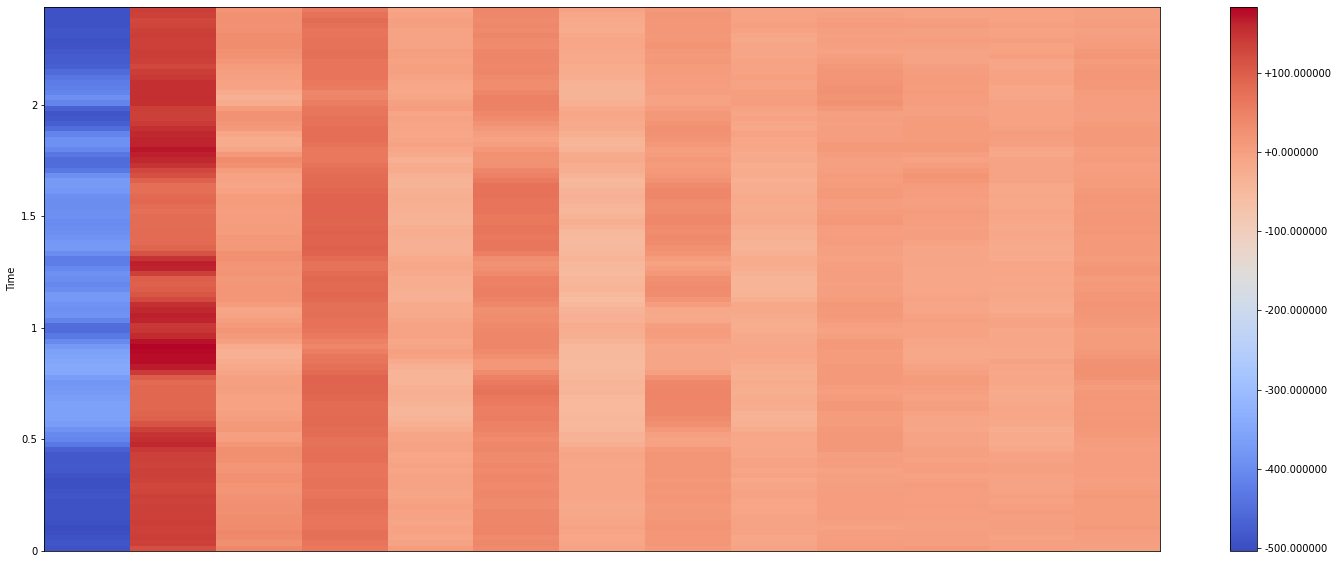

In [8]:
#Visualize MFCCs
plt.figure(figsize=(25,10))
librosa.display.specshow(data["mfcc"][0], y_axis = "time", sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [9]:
data["mfcc"][0].shape

(105, 13)

In [10]:
'''delta_mfcc = []
delta2_mfcc = []
for i in range(7442):
    delta_mfcc.append(librosa.feature.delta(data["mfcc"][i]))
    delta2_mfcc.append(librosa.feature.delta(data["mfcc"][i],order=2))
    comprehensive_mfcc = np.concatenate(data["mfcc"][i],delta_mfcc[i],delta2_mfcc)'''

'delta_mfcc = []\ndelta2_mfcc = []\nfor i in range(7442):\n    delta_mfcc.append(librosa.feature.delta(data["mfcc"][i]))\n    delta2_mfcc.append(librosa.feature.delta(data["mfcc"][i],order=2))\n    comprehensive_mfcc = np.concatenate(data["mfcc"][i],delta_mfcc[i],delta2_mfcc)'

In [11]:
X = np.asarray(data['mfcc'])
y = np.asarray(data["labels"])
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 216, 13)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [14]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 216, 13) (5357,) (1340, 216, 13) (1340,) (745, 216, 13) (745,)


In [15]:
def create_model_LSTM(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True,))
    model.add(LSTM(64))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model_LSTM((None,13))

In [16]:
# Training 
model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=40)

Epoch 1/40
168/168 [==============================] - 65s 367ms/step - loss: 1.8402 - accuracy: 0.2485 - val_loss: 1.5313 - val_accuracy: 0.3560
Epoch 2/40
168/168 [==============================] - 62s 367ms/step - loss: 1.6146 - accuracy: 0.3234 - val_loss: 1.5008 - val_accuracy: 0.3619
Epoch 3/40
168/168 [==============================] - 61s 363ms/step - loss: 1.5554 - accuracy: 0.3481 - val_loss: 1.5005 - val_accuracy: 0.3545
Epoch 4/40
168/168 [==============================] - 60s 358ms/step - loss: 1.5302 - accuracy: 0.3603 - val_loss: 1.4719 - val_accuracy: 0.4045
Epoch 5/40
168/168 [==============================] - 60s 356ms/step - loss: 1.5140 - accuracy: 0.3744 - val_loss: 1.4734 - val_accuracy: 0.3948
Epoch 6/40
168/168 [==============================] - 60s 360ms/step - loss: 1.5011 - accuracy: 0.3688 - val_loss: 1.4712 - val_accuracy: 0.3978
Epoch 7/40
168/168 [==============================] - 61s 366ms/step - loss: 1.4891 - accuracy: 0.3911 - val_loss: 1.4532 - val_ac

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.5167785286903381


In [18]:
model.save("sentiment_analysis_model_v1.h5")